In [2]:
import numpy as np 
import pandas as pd
import allel
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import malariagen_data
%matplotlib inline
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe

In [3]:
cohorts = [
    # Ag1000G phase 3 Ghana sample set in Ag3.0
    "AG1000G-GH",
    # Amenta-Etego sample sets in Ag3.3
    #'1190-VO-GH-AMENGA-ETEGO-VMF00013',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00014',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00028',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00029',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00046',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00047',
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    'AG1000G-ML-A',
    'AG1000G-BF-A',
    'AG1000G-BF-B',
    'AG1000G-GN-A',
    'AG1000G-GN-B',
    # GAARD Ghana sample set in Ag3.2
    "1244-VO-GH-YAWSON-VMF00051",
    '1245-VO-CI-CONSTANT-VMF00054',
    '1253-VO-TG-DJOGBENOU-VMF00052',
    '1237-VO-BJ-DJOGBENOU-VMF00050'
]

## GWSS Figure 1
Could try and do a line for each country and double lines for species 

In [4]:
def plotChromLines(ax0, left_arm_start=None, left_arm_end=None, right_arm_start=None, right_arm_end=None, contig='autosome'):
    # start vertical line
    if contig == 'autosome':
        l = matplotlib.lines.Line2D([right_arm_end,right_arm_end], [4,6], color='#36454F', linewidth=3)   #line 
        ax0.add_line(l)
        # end vertical line
        l = matplotlib.lines.Line2D([right_arm_end,right_arm_end], [4,6], color='#36454F', linewidth=3)   #line 
        ax0.add_line(l)
        # left arm top line and bottom line
#         l = matplotlib.lines.Line2D([left_arm_start,left_arm_end-5000000], [4,4], color='#36454F', linewidth=3)
#         ax0.add_line(l)
#         l = matplotlib.lines.Line2D([left_arm_start,left_arm_end-5000000], [6,6], color='#36454F', linewidth=3)
#         ax0.add_line(l)
        # right arm top line and bottom line
        l = matplotlib.lines.Line2D([right_arm_start+5000000,right_arm_end], [4,4], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([right_arm_start+5000000,right_arm_end], [6,6], color='#36454F', linewidth=3)
        ax0.add_line(l)
        # angled lines 
#         l = matplotlib.lines.Line2D([left_arm_end-5000000,left_arm_end], [4,4.5], color='#36454F', linewidth=3)
#         ax0.add_line(l)
#         l = matplotlib.lines.Line2D([left_arm_end-5000000,left_arm_end], [6,5.5], color='#36454F', linewidth=3)
#         ax0.add_line(l)
        l = matplotlib.lines.Line2D([right_arm_start+5000000,right_arm_start], [4,4.5], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([right_arm_start+5000000,right_arm_start], [6,5.5], color='#36454F', linewidth=3)
        ax0.add_line(l)
#         # end vertical line
#         l = matplotlib.lines.Line2D([left_arm_start, left_arm_start], [4,6], color='#36454F', linewidth=3)   #line 
#         ax0.add_line(l)

#         # left arm top line and bottom line
#         l = matplotlib.lines.Line2D([left_arm_start,left_arm_end-5000000], [4,4], color='#36454F', linewidth=3)
#         ax0.add_line(l)
#         l = matplotlib.lines.Line2D([left_arm_start,left_arm_end-5000000], [6,6], color='#36454F', linewidth=3)
#         ax0.add_line(l)

#         ## end 
#         l = matplotlib.lines.Line2D([left_arm_end-5000000,left_arm_end], [4,4.5], color='#36454F', linewidth=3)
#         ax0.add_line(l)
#         l = matplotlib.lines.Line2D([left_arm_end-5000000,left_arm_end], [6,5.5], color='#36454F', linewidth=3)
#         ax0.add_line(l)

        
def setupAxes(ax, maxbp, sample=None, xaxis=True, title=False, contig=None):
    ax.set_ylim(3,6.25)
    ax.set_xlim(0, maxbp)
    if sample != None: 
        ax.set_ylabel(sample, rotation=0, ha='right', fontsize=16)
        ax.set_yticks([])
        ax.yaxis.set_label_coords(-0.01,0.41)
    else:
        ax.axes.get_yaxis().set_visible(False)
    xtick = np.arange(0, maxbp, 10000000)
    ax.set_xticks(xtick, fontsize=42)
    ax.ticklabel_format(style='sci',scilimits=(6,6),axis='x')
    if xaxis == False:
        ax.axes.get_xaxis().set_visible(False)
        sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    else:
        sns.despine(top=False, right=False, left=False, bottom=False, ax=ax)
        

def addInversion(ax, start, size, freq=None, inversion = '2La', color='indianred'):
    ### Add inversions ###
    # Create a Rectangle patch
    rect = patches.Rectangle((start, 4), size, 2, linewidth=3,
                            edgecolor='none', facecolor=color, alpha=freq)
    ax.add_patch(rect)

    # start vertical line
    l = matplotlib.lines.Line2D([start, start], [4, 6], color="grey", linewidth=3, linestyle='--', zorder=0)   #line 
    ax.add_line(l)
    l = matplotlib.lines.Line2D([start+size, start+size], [4, 6], color="grey", linewidth=3, linestyle='--',zorder=0)   #line 
    ax.add_line(l)

    mid =  start + (size/2)
    # add freq
    if inversion == '2Rb':
        ax.annotate(inversion, xy=(mid-2_500_000,5.2),# rotation=90,
               size=18)
    else:
        ax.annotate(inversion, xy=(mid-2_000_000,4.6),# rotation=90,
               size=18, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=0.2))    


In [4]:
contigs = pd.read_csv("/home/sanj/ag1000g/data/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa.fai", sep="\t", header=None)
contigs = contigs.rename(columns={0:'contig', 1:'end'}).query("contig in ['2R', '2L', '3L', '3R', 'X']")
contigs = contigs.drop(columns=[2,3,4])
contigs['start'] = 0
# new column for whole chrom as these will be subplots
contigs['chromosome'] = contigs['contig'].str.replace("R", "").str.replace("L", "")

# Designate inversion breakpoints
# inversion 2La
inv2la_start = 20524058
inv2la_end   = 42165532 
inv2la_size = inv2la_end-inv2la_start

h_2l = np.array([[0, 2487770], [5042389, 5788875]])

maxbp = contigs.query("contig == '2L'")['end'].to_numpy()[0]
maxbp2r = contigs.query("contig == '2R'")['end'].to_numpy()[0]

gff3 = allel.gff3_to_dataframe("/home/sanj/projects/IR/rna-seq-busia/resources/reference/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3", attributes=['ID'])
gff = gff3.query("type == 'gene' & seqid == '2L'")
gff['midpoint'] = (gff3['end'] + gff3['start']) / 2

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
cohorts = np.array(cohorts)

Load the H123 data

In [6]:
midp_dict = {}
h123_dict = {}

for cohort in cohorts[cohorts != '1237-VO-BJ-DJOGBENOU-VMF00050']:
    df  = pd.read_csv(f"../../results/{cohort}.h123.tsv", sep="\t", index_col=0).T
    h123_dict[cohort] = df.iloc[:,0]
    midp_dict[cohort] = df.iloc[:,1]

colours = probe.get_colour_dict(cohorts)

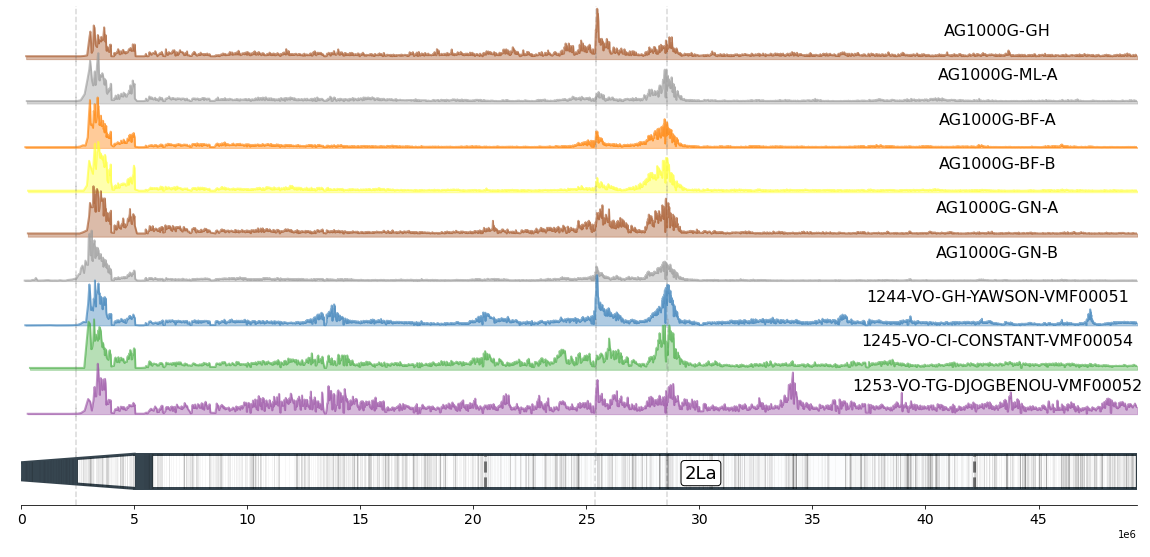

In [223]:
fig, ax = plt.subplots(len(cohorts)+2, 1, figsize=[20,10])

for axes in ax:
    axes.set_facecolor('white')
    # Set transparency of figure
    axes.patch.set_alpha(0)
    axes.set_clip_on(False)
    axes.set_yticklabels([])
    axes.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    axes.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes.set(ylabel=" ")

for idx, cohort in enumerate(cohorts[cohorts != '1237-VO-BJ-DJOGBENOU-VMF00050']):
    # Plot lineplot and fill underneath with alpha
    sns.lineplot(ax=ax[idx],x=midp_dict[cohort], y=h123_dict[cohort], linewidth=2, color=colours[cohort], alpha=0.6)
    ax[idx].fill_between(midp_dict[cohort], h123_dict[cohort] , color=colours[cohort], alpha=0.4)
    
    ax[idx].set_xlim(0, max(midp_dict[cohort]))
    sns.despine(ax=ax[idx], left=True, bottom=True)
    ax[idx].set_yticks([], [])
    
    ax2 = ax[idx].twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(cohort, labelpad=-125, rotation=0, fontsize=16)
    ax2.yaxis.set_label_coords(0.875, 0.7)
    ax2.tick_params(axis='y', which='both', right=False, left=False, labelleft=False, labelright=False) 
    sns.despine(ax=ax2, left=True, bottom=True)

    plt.subplots_adjust(hspace=-0.2)
    
    
### Do chrom plot
gidx = len(cohorts)
sns.lineplot(ax=ax[gidx-1],x=midp_dict[cohort], y=h123_dict[cohort], color='w', alpha=0)
sns.despine(ax=ax[gidx-1], bottom=True, left=True)
ax[gidx-1].set_xlim(0, midp_dict[cohort].max())
ax[gidx-1].tick_params(axis='x', which='both',       # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

sns.lineplot(ax=ax[gidx+1],x=midp_dict[cohort], y=h123_dict[cohort], color='w', alpha=0)
sns.despine(ax=ax[gidx+1], bottom=True, left=True)
ax[gidx+1].set_xlim(0, midp_dict[cohort].max())
ax[gidx+1].tick_params(axis='x', which='both',       # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

setupAxes(ax=ax[gidx], maxbp=maxbp)
plotChromLines(ax0=ax[gidx], right_arm_start=0, right_arm_end=maxbp)
addInversion(ax=ax[gidx], start=inv2la_start, size=inv2la_size, freq=0.01, inversion='2La', color=None)
sns.despine(ax=ax[gidx], bottom=False, left=True)
t3 = plt.Polygon([[h_2l[0][0],4.5], [h_2l[0][0],5.5],
                    [h_2l[0][1],5.75], [h_2l[0][1], 4.25]], color='#36454F')
ax[gidx].add_patch(t3)
t3 = plt.Polygon([[h_2l[1][0],4], [h_2l[1][0], 6],
                    [h_2l[1][1],6], [h_2l[1][1], 4]], color='#36454F')
ax[gidx].add_patch(t3)

ax[gidx].tick_params(axis='x', which='both', bottom=True, labelbottom=True)
xtick = np.arange(0, maxbp, 5000000)
ax[gidx].set_xticks(xtick)
ax[gidx].xaxis.set_tick_params(labelsize=14)
ax[gidx].ticklabel_format(style='sci',scilimits=(6,6),axis='x')


x = [0, 5_000_000]
lowers = [4.5, 4]
uppers = [5.5, 6]
    
for _, row in gff.iterrows():
    pos = row['midpoint']
    lower = np.interp(pos, x, lowers)
    upper = np.interp(pos, x, uppers)
            # start vertical line
    l = matplotlib.lines.Line2D([pos, pos], [lower, upper], color="k", linewidth=1, alpha=0.03)   #line 
    ax[gidx].add_line(l)


for axes in ax[:-1]:
    axes.axvline(2_422_652, linestyle='--', clip_on=False, alpha=0.3, color="grey", zorder=0)
    axes.axvline(25_400_000, linestyle='--', clip_on=False, alpha=0.3, color="grey", zorder=0)
    axes.axvline(28_547_000, linestyle='--', clip_on=False, alpha=0.3, color="grey", zorder=0)

plt.savefig("../../figures/upperEvidence.png", dpi=300)

In [7]:
def plotGenes(ax, start=28_524_224, stop=28_551_000, contig='2L'):

    gff3 = allel.gff3_to_dataframe("/home/sanj/projects/IR/rna-seq-busia/resources/reference/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3", attributes=['ID', 'Parent'])
    gff3 = gff3.query("start > @start & end < @stop")
    genegff = gff3.query("type == 'gene' & seqid == @contig")
    locgff = gff3.query("type == 'exon' & seqid == @contig")

    min_= locgff.start.min()
    max_ = locgff.end.max()

    ax.set_xlim(min_, max_)
    ax.set_ylim(-0.5, 2)
    ax.axhline(0.5, color='k', linewidth=3)
    ax.set_yticks(ticks=[0.2,1.2], labels=['- ', '+'], size=20)
    ax.tick_params(top=False,
               left=False,
               right=False,
               labelleft=True,
               labelbottom=True)
    ax.tick_params(axis='x', which='major', labelsize=13)
    ax.set_ylabel("Genes")
    ax.set_xlabel(f"Chromosome {contig} position", fontdict={'fontsize':14})

    for _, exon in locgff.iterrows():
        start, end = exon[['start', 'end']]
        strand = exon['strand']
        if strand == '+':
            rect = patches.Rectangle((start, 0.55), end-start, 0.3, linewidth=3,
                                edgecolor='none', facecolor="grey", alpha=0.9)
        else:
            rect = patches.Rectangle((start, 0.45), end-start, -0.3, linewidth=3,
                                edgecolor='none', facecolor="grey", alpha=0.9)
        ax.add_patch(rect)

    for _, gene in genegff.iterrows():
        start, end = gene[['start', 'end']]
        size = end-start
        corr = size/4
        strand = gene['strand']
        if strand == '+':
            rect = patches.Rectangle((start, 0.55), end-start, 0.3, linewidth=3,
                                edgecolor='black', facecolor="none")
            ax.text(((start+end)/2)-corr, 0.95, s=gene['ID'], fontdict= {'fontsize':12})
        else:
            rect = patches.Rectangle((start, 0.45), end-start, -0.3, linewidth=3,
                                edgecolor='black', facecolor="none")
            ax.text(((start+end)/2)-corr,  -0.3, s=gene['ID'], fontdict= {'fontsize':12})
        ax.add_patch(rect)


In [227]:
d = {}
r = {}

sps = ['gambiae', 'coluzzi','arabiensis']
for sp in sps:
    expr = pd.read_csv(f"../../results/expression/swept_genes_expr_Anopheles {sp}.csv").rename(columns={'Unnamed: 0':'gene'})

    read_diff = expr.loc[expr['gene'].str.contains('diff')]
    expr = expr.loc[~expr['gene'].str.contains('diff')]
    expr = expr.drop(columns='means')
    expr = expr.melt('gene', var_name='Population', value_name='FC')
    expr['species'] = sp
    expr['FC'] = np.log2(expr['FC'])
    read_diff.drop(columns='means')
    read_diff = read_diff.melt('gene', var_name='Population', value_name='read_difference')
    read_diff['species'] = sp
    d[sp] = expr
    r[sp] = read_diff
    
expr = pd.concat(d)
read = pd.concat(r)
genes_exclude = expr['gene'][:2].to_list()
genes_exclude
expr = expr.query("gene not in @genes_exclude")
a = sns.color_palette("Set1", 3)

In [228]:
start=28_524_224
stop=28_551_000

gff3 = allel.gff3_to_dataframe("/home/sanj/projects/IR/rna-seq-busia/resources/reference/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3", attributes=['ID', 'Parent'])
gff3 = gff3.query("start > @start & end < @stop")
genegff = gff3.query("type == 'gene' & seqid == '2L'")
locgff = gff3.query("type == 'exon' & seqid == '2L'")
gaps_df = pd.DataFrame({'seqid':'2L', 'ID':genegff.loc[:,'ID'], 'type':'gap', 'start':genegff.loc[:,'end'], 'end':genegff.loc[:,'start'].shift(-1)})[:-1]
genes_df = pd.concat([genegff[gaps_df.columns], gaps_df], axis=0).sort_values(by='start')

In [229]:
genes_df.loc[:, 'size'] = genes_df.loc[:,'end'] - genes_df.loc[:,'start']
genes_df.loc[:, 'ratio'] = genes_df.loc[:, 'size'] / 2092
genes_df = genes_df.reset_index(drop=True)

In [230]:
from matplotlib.gridspec import GridSpec

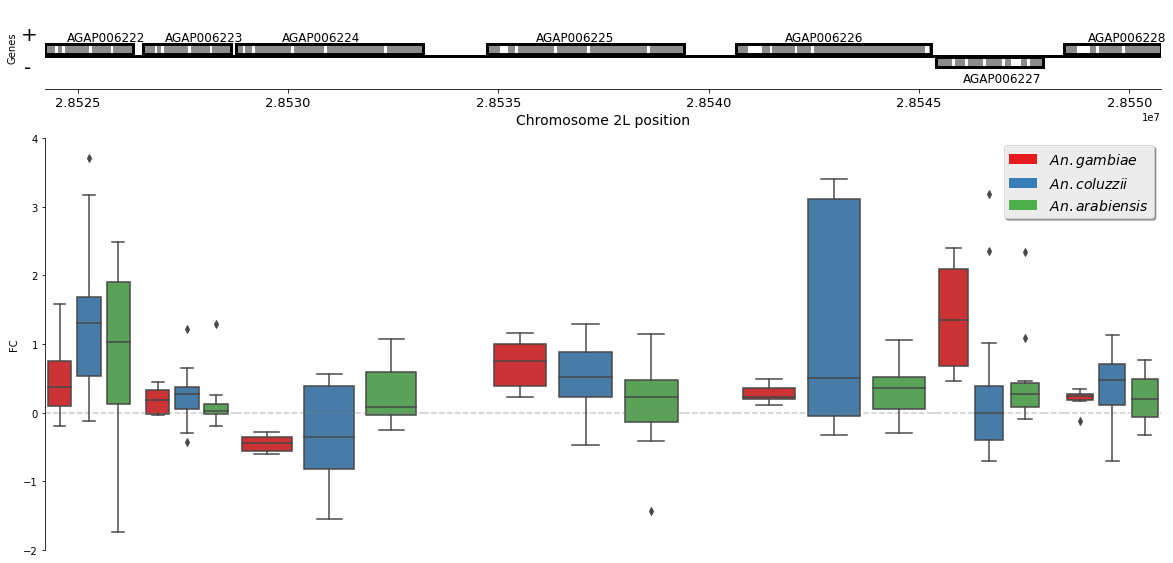

In [235]:
ax_list = []

fig = plt.figure(figsize=[20,10])
gs = GridSpec(2, genes_df.shape[0], figure=fig, height_ratios=[1,5], width_ratios=genes_df.loc[:, 'ratio'].to_list())

ax1 = fig.add_subplot(gs[0,:])

for i in range(genes_df.shape[0]):
    ax_list.append(fig.add_subplot(gs[1, i]))

fig.subplots_adjust(wspace=0)

plotGenes(ax=ax1)
sns.despine(ax=ax1, left=True, bottom=False, right=True, top=True)

sns.despine(ax=ax_list[0], left=False, bottom=True)
ax_list[0].set_xticks([])
ax_list[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_list[0].axes.axes.get_xaxis().get_label().set_visible(False)
ax_list[0].axhline(0, ls='--', c='grey', alpha=0.4,  clip_on=False, zorder=0)
ax_list[0].set_ylim(-2, 4)


for axes in ax_list[1:]:
    sns.despine(ax=axes, left=True, bottom=True)
    axes.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axes.tick_params(axis='y', which='both', left=False)
    axes.set(xlabel=None, ylabel=None)
    axes.set_yticks([])
    axes.axes.get_xaxis().get_label().set_visible(False)
    axes.axes.get_yaxis().get_label().set_visible(False)
    axes.axhline(0, ls='--', c='grey', alpha=0.4,  clip_on=False)
    axes.set_ylim(-2, 4)

for idx, row in genes_df.iterrows():
    if row['type'] == 'gap':
        continue
    
    gene = row['ID']
    
    sns.boxplot(
            zorder=10,
            x="species",
            y="FC",
            data=expr.query("gene == @gene"),
            ax=ax_list[idx], 
            palette=a)

a1 = plt.Rectangle((0,0),1,1,fc=a[0], edgecolor = 'none')
a2 = plt.Rectangle((0,0),1,1,fc=a[1],  edgecolor = 'none')
a3 = plt.Rectangle((0,0),1,1,fc=a[2],  edgecolor = 'none')
l = plt.legend([a1, a2, a3], 
                ['$\it{An. gambiae}$', '$\it{An. coluzzii}$', '$\it{An. arabiensis}$'],
                loc='best',# bbox_to_anchor=(1, 0.95),
            ncol=1, fancybox=True, shadow=True, prop={'size':14}, framealpha=0.8)
l.draw_frame(True)
plt.savefig("../../figures/lowerEvidence.png", dpi=300)



In [6]:
import numpy as np
2^4

6

#### Plot CNV breakpoints

In [21]:
moshi_dup_start, moshi_dup_end = 28535653, 28571586
gaard_dup_start, gaard_dup_end = 28542695, 28551033

In [7]:
fig, ax1 = plt.subplots(1,1, figsize=[30,4])
plotGenes(ax=ax1, stop=28_579_000)
sns.despine(ax=ax1, left=True, bottom=False, right=True, top=True)
ax1.arrow(moshi_dup_start, ls='--',lw=3, c='springgreen', alpha=0.8, clip_on=False, zorder=0)
ax1.axvline(moshi_dup_end,ls='--',lw=3, c='springgreen', alpha=0.8,  clip_on=False, zorder=0)
ax1.axvline(gaard_dup_start, ls='--',lw=3, c='indianred', alpha=0.8,  clip_on=False, zorder=0)
ax1.axvline(gaard_dup_end, ls='--',lw=3, c='indianred', alpha=0.8,  clip_on=False, zorder=0)


NameError: name 'plt' is not defined

In [43]:
# fig, ax = plt.subplots(2,1, figsize=[20,8])
# my_pal = {"gambiae": "indianred", "coluzzi": "dodgerblue", "arabiensis":"limegreen"}
# ax[1].axhline(0, ls='--', c='grey', alpha=0.4)
# sns.swarmplot(ax=ax[1], data=expr, x='gene', y='FC', hue='species', palette=a)
# for i, sp in enumerate(sps):
#     sns.boxplot(showmeans=True,
#             meanline=True,
#             meanprops={'color': a[i], 'ls': '--', 'lw': 3, 'alpha':0.9},
#             medianprops={'visible': False},
#             whiskerprops={'visible': False},
#             zorder=10,
#             x="gene",
#             y="FC",
#             data=expr.query(f"species == '{sp}'"),
#             showfliers=False,
#             showbox=False,
#             showcaps=False,
#             ax=ax[1])

# ax[1].tick_params(axis="y", labelsize=16)
# ax[1].tick_params(axis="x", labelsize=16)
# ax[1].set_ylabel("Log2 Fold Change", fontsize=16)
# plt.xticks(rotation=90)